In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!rm spark-2.4.5-bin-hadoop2.7.tgz
!wget --no-cookies --no-check-certificate https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar zxvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

In [0]:
import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import datetime, time
import pandas as pd 
import seaborn as sns
import re, random, sys

# Note - Not all of these will be used, but I've added them for your reference as a "getting started"
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, IntegerType, StringType, FloatType, LongType, DateType
from pyspark.sql.functions import struct, array, lit, monotonically_increasing_id, col, expr, when, concat, udf, split, size, lag, count, isnull
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GBTRegressor, LinearRegression, GeneralizedLinearRegression, RandomForestRegressor
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Load Bank Attrition Data 


In [2]:
!wget https://raw.githubusercontent.com/zaratsian/Datasets/master/banking_attrition.csv

--2020-03-28 16:06:35--  https://raw.githubusercontent.com/zaratsian/Datasets/master/banking_attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021593 (3.8M) [text/plain]
Saving to: ‘banking_attrition.csv’

banking_attrition.c 100%[===================>]   3.83M  --.-KB/s    in 0.1s    

2020-03-28 16:06:36 (38.0 MB/s) - ‘banking_attrition.csv’ saved [4021593/4021593]



In [0]:
spark = SparkSession.builder.appName("Spark ML Assignment").master("local[*]").getOrCreate()

In [0]:
bank_atr = spark.read.load('banking_attrition.csv', format="csv", header=True, inferSchema=True)

# Get Familiar with the *Data*

In [12]:
# DISPLAY COLUMNS
print('COLUMN NAMES') 
bank_atr.columns

COLUMN NAMES


['uid',
 'age',
 'age_group',
 'profession',
 'marital_status',
 'education',
 'default',
 'housing',
 'loan',
 'gender',
 'balance',
 'membership',
 'charges',
 'customer_contacts',
 'attrition']

In [11]:
# PRINT OUT DATA TYPES OF EACH COLUMN 
print('COLUMN DATA TYPES')
bank_atr.dtypes

COLUMN DATA TYPES


[('uid', 'int'),
 ('age', 'int'),
 ('age_group', 'string'),
 ('profession', 'string'),
 ('marital_status', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('gender', 'string'),
 ('balance', 'string'),
 ('membership', 'string'),
 ('charges', 'int'),
 ('customer_contacts', 'int'),
 ('attrition', 'int')]

In [13]:
# DATASET SIZE
print('DATA SIZE:')
bank_atr.count()

DATA SIZE:


45211

# Exploratory Analysis of the Features

In [48]:
bank_atr_pd = bank_atr.toPandas()# convert to pandas dataframe 
#bank_atr_pd.age_group.dtype
#cols = list(bank_atr_pd.columns)
for c in list(bank_atr_pd.columns):
  if bank_atr_pd[c].dtype == "O":
    print(c.upper(), 'Distribution( as proportion)')
    print(bank_atr_pd[c].value_counts(normalize = True))
    print('------------------')
  else:
    print(c.upper(), 'Statistics ')
    print(bank_atr_pd[c].describe())
    print('------------------')




UID Statistics 
count    4.521100e+04
mean     1.022606e+06
std      1.305144e+04
min      1.000001e+06
25%      1.011304e+06
50%      1.022606e+06
75%      1.033908e+06
max      1.045211e+06
Name: uid, dtype: float64
------------------
AGE Statistics 
count    45211.000000
mean        41.063546
std         11.678363
min         18.000000
25%         32.000000
50%         40.000000
75%         51.000000
max         95.000000
Name: age, dtype: float64
------------------
AGE_GROUP Distribution( as proportion)
30s    0.318507
50s    0.252527
40s    0.215611
20s    0.177921
60s    0.024131
70s    0.008007
80s    0.002367
U20    0.000796
90s    0.000133
Name: age_group, dtype: float64
------------------
PROFESSION Distribution( as proportion)
management        0.185928
manufacturing     0.185154
technician        0.150561
administration    0.146867
unemployed        0.097012
consulting        0.079450
retired           0.045586
self_employed     0.031099
entrepreneur      0.029396
executive

In [87]:
# DISTRIBUTION OF OUR BINARY TARGET VARIABLE
bank_atr_pd.attrition.value_counts(normalize= True)

0    0.774391
1    0.225609
Name: attrition, dtype: float64

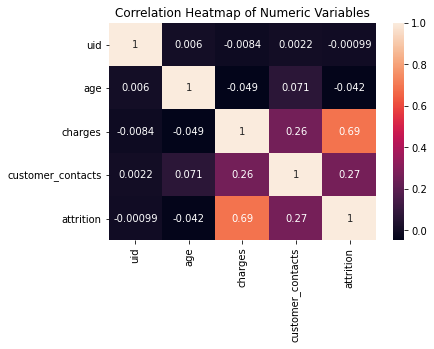

In [58]:
# HEATMAP OF CORRELATIONS(numeric variables only)
import matplotlib.pyplot as plt

cor = bank_atr_pd.corr()

ax = plt.axes()
sns.heatmap(cor, annot=True)

ax.set_title('Correlation Heatmap of Numeric Variables')
plt.show()

# Build Model


In [0]:
# IIMPORT LOGISTIC REGRESSION PACKAGE
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


In [81]:
# Encode string data as integers
string_cols = ['age_group', 'profession', 'marital_status', 'education', 'default', 'housing', 'loan', 'gender', 'balance', 'membership']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(bank_atr) for column in string_cols ]


# create a pipline for  the encoding 
pipeline = Pipeline(stages=indexers)
bank_atr_indexed = pipeline.fit(bank_atr).transform(bank_atr)


# create feature vector and define target target variable

features = ['age_group_index', 'profession_index', 'marital_status_index', 'education_index', 'default_index', 'housing_index', 'loan_index', 'gender_index', 'balance_index',
            'membership_index', 'charges', 'customer_contacts']
target = 'attrition'

vectorAssembler = VectorAssembler(inputCols = features  , outputCol = 'features')
bank_atr_indexed = vectorAssembler.transform(bank_atr_indexed)

bank_atr_indexed = bank_atr_indexed.select(['features', 'attrition'])
bank_atr_indexed.show(5, False)


#split data into train and test 
train, test = bank_atr_indexed.randomSplit([0.7, 0.3], seed=12345)

# create model object(logistic regression)
lr = LogisticRegression(featuresCol = 'features' ,  labelCol = target, maxIter=10, regParam=0.001)
m = lr.fit(train)

#predict on test data
prediction = m.transform(test)
prediction.show(10,False)




+---------------------------------------------------+---------+
|features                                           |attrition|
+---------------------------------------------------+---------+
|[4.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,74.0,5.0] |0        |
|[2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,149.0,1.0]|0        |
|(12,[0,3,5,8,10,11],[2.0,1.0,1.0,2.0,58.0,5.0])    |1        |
|[1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,317.0,4.0]|1        |
|[0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,139.0,8.0]|0        |
+---------------------------------------------------+---------+
only showing top 5 rows

+-----------------------------------------------+---------+----------------------------------------+-----------------------------------------+----------+
|features                                       |attrition|rawPrediction                           |probability                              |prediction|
+-----------------------------------------------+---------+--------------------------------

In [86]:
# Fit Stats
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="attrition",metricName="rmse")

print('RMSE FOR TEST DATA')
lr_evaluator.evaluate(prediction)

RMSE FOR TEST DATA


0.24900762550092123